## Calculate surface-forced watermass transformation
Presently, information about the products, e.g. names of variables is hard-coded. Could improve robustness by specifying generic names.

In [109]:
%load_ext autoreload
%autoreload 2
from dask.diagnostics import ProgressBar
import so_decadal_variability as so
import numpy as np
import xarray as xr
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
fluxname='era5'
oceanname='en4'
timeslice = slice('1980','2018')
dg = 0.1
gn_edges = np.arange(1026,1028.5,dg)
save = False
ds = so.process.loaddata(fluxname,oceanname,timeslice)
ds, xgrid = so.grid.get_xgcm(ds)
# Hack to get around grid errors in IAP for now
if oceanname=='iap':
    ds['vol4d'] = ds['dx']*ds['dy']*ds['dz']*xr.ones_like(ds['vol4d'])
b_cap = False
cap = 5
if b_cap:
    condition = (ds['b']>cap) & (~np.isnan(ds['b']))
    ds['b'] = ds['b'].where(~condition,cap)
G = so.wmt.calc_watermasstransformation(ds,xgrid,gn_edges,b_ones=False)
if save:
    with ProgressBar():
        localdir = '../data/processed/'+fluxname+'_'+oceanname
        if ~os.path.isdir(localdir):
            !mkdir $localdir
        filename = 'G_'+str(dg)+'.nc'
        G.to_netcdf(localdir+'/'+filename)

In [111]:
with ProgressBar():
    G.load()

[########################################] | 100% Completed | 57.6s


In [112]:
# SEVERE hack to solve NaN issue (caused by NaNs in the gamman field)
if oceanname=='iap':
    val = G['gamman_bin'].sel(gamman_bin=1027.75,method='nearest')
    G['heat'].loc[dict(time='2002-10-01',gamman_bin=val)]=2E10
    G['total'].loc[dict(time='2002-10-01',gamman_bin=val)]=G['heat'].loc[dict(time='2002-10-01',gamman_bin=val)]+G['fw'].loc[dict(time='2002-10-01',gamman_bin=val)]

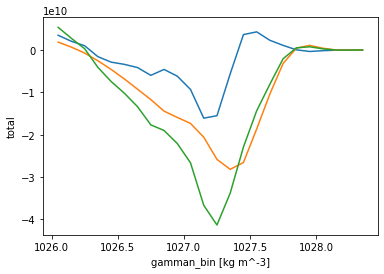

In [113]:
G['heat'].mean('time').plot()
G['fw'].mean('time').plot()
G['total'].mean('time').plot()

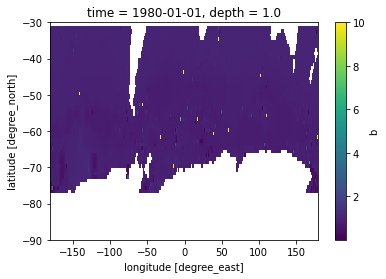

In [99]:
ds['b'].isel(depth=0,time=0).plot()